In [1]:
import cv2
import numpy as np
from scipy import ndimage
from copy import copy
from numpy import linalg as LA
import matplotlib
import matplotlib.pyplot as plt
import os
import ast
import re

In [2]:
#Setup the graphs
matplotlib.rcParams.update({'font.size': 11})

In [3]:
def load_image_CR(filename, directory):
    frame_in = cv2.imread(os.path.join(directory, filename))
    frame_in = frame_in.astype(np.float32)
    frame_in = frame_in[:, :, 1]
    return frame_in

In [4]:
def cramer_rao(frame_threshold, axis_input):
    gain = 1.0
    total_flux_adu = np.sum(frame_threshold)
    if axis_input == 'x':
        axis_no = 0
    elif axis_input == 'y':
        axis_no = 1
    distribution = np.sum(frame_threshold, axis = axis_no)
    half_maximum = 0.5 * np.max(distribution)
    FWHM = np.count_nonzero(distribution >= half_maximum)
    CR_lower_bound = np.sqrt((1.0/(8.0*np.log(2.0))) * (1.0/(gain*total_flux_adu)) * (FWHM**2))
    return CR_lower_bound, FWHM

In [5]:
#Load a frame as a 2D array of pixel values. If the frame is RGB, return the green channel of the image (for frames taken with an autocollimator) or return the difference between the green channel and the average of the red and blue channels (for frames taken with a distance sensor). This helps to distinguish the green laser spot from background noise.
def load_image(filename, directory, device = 'autocollimator', grayscale = True):
  if grayscale:
    frame_in = cv2.imread(os.path.join(directory, filename), cv2.IMREAD_GRAYSCALE)
    frame_in = frame_in.astype(np.float32)
  elif not grayscale:
    frame_in = cv2.imread(os.path.join(directory, filename))
    frame_in = frame_in.astype(np.float32)
    if (device == 'autocollimator'):
      frame_in = frame_in[:, :, 1]
    elif (device == 'distance_sensor'):
      frame_in = frame_in[:, :, 1] - ((frame_in[:, :, 0] + frame_in[:, :, 2]) / 2.0)
  return frame_in

In [6]:
#Threshold an input frame by comparing the intensity of each pixel with a threshold value. If the pixel intensity is above the threshold, it is set to the difference between the pixel and threshold values, otherwise, it is set to 0.
def threshold_image(frame_in, threshold):
  fraction = 1.0 - threshold #Keep the fraction of the image above the threshold
  frame_threshold = copy(frame_in)
  frame_threshold += ((frame_threshold.max() - frame_threshold.min()) * fraction) - frame_threshold.max()
  frame_threshold = cv2.threshold(frame_threshold, 0, 0, cv2.THRESH_TOZERO)[1]
  return frame_threshold

In [7]:
#Return the centre of mass coordinates of the intensity distribution in an input frame
def spot_centre(frame_threshold):
  peak = ndimage.measurements.center_of_mass(frame_threshold)
  peak = (peak[1], peak[0])
  return peak

In [8]:
#Return the second momoments ratio of the intensity distribution in an input frame. This parameter is defined as the ratio between the second moments about the principal axes and it is calculated using the covariance matrix. Its value maximises at 1 for a circular spot with a normal intensity distribution. The linear functions defining the major and minor principle axis are also returned.
def spot_second_moments_ratio(frame_threshold, peak):
  frame_copy = copy(frame_threshold)
  frame_bool = copy(frame_threshold)
  total = np.sum(frame_copy)
  xp, yp = np.meshgrid(np.arange(np.shape(frame_bool)[1]), np.arange(np.shape(frame_bool)[0]))
  xp = xp.astype(np.float64)
  yp = yp.astype(np.float64)
  xp -= peak[0] #xp is the seperation between a pixel and the centre of mass in x
  yp -= peak[1] #yp is the seperation between a pixel and the centre of mass in y
  frame_bool = frame_bool.astype(bool) # To speed up image processing, only perform calculations on the high pixels
  x2 = np.sum(frame_copy[frame_bool] * xp[frame_bool]**2) / total
  y2 = np.sum(frame_copy[frame_bool] * yp[frame_bool]**2) / total
  xy = np.sum(frame_copy[frame_bool] * xp[frame_bool] * yp[frame_bool]) / total
  covariance = np.array([[x2, xy], [xy, y2]])
  eigenvalue, eigenvector = LA.eig(covariance)
  if eigenvector[0, 0] == 0.0: #Evaluate the linear functions defining the major and minor principal axes
    m1 = np.inf
    c1 = np.nan
  if eigenvector[0, 0] != 0.0:
    m1 = eigenvector[1, 0] / eigenvector[0, 0]
    c1 = peak[1] - (peak[0] * m1)
  if eigenvector[0, 1] == 0.0:
    m2 = np.inf
    c2 = np.nan
  if eigenvector[0, 1] != 0.0:
    m2 = eigenvector[1, 1] / eigenvector[0, 1]
    c2 = peak[1] - (peak[0] * m2)
  if eigenvalue[0] > eigenvalue[1]: #Evaluate the second moments ratio, ensure its value maximises at 1
    second_moments_ratio = eigenvalue[1] / eigenvalue[0]
  if eigenvalue[1] > eigenvalue[0]:
    second_moments_ratio = eigenvalue[0] / eigenvalue[1]
  if eigenvalue[0] == eigenvalue[1]:
    second_moments_ratio = 1.0
  return second_moments_ratio, m1, m2, c1, c2

In [9]:
#Return the kurtosis of the intensity distribution in an input frame. This parameter is defined as the ratio between the fourth moment and the second moment squared. Its expected value is 3 for a normal distribution, higher values indicate the tails of the distribution are fattened by background noise.
def spot_kurtosis(frame_threshold, peak):
  frame_copy = copy(frame_threshold)
  frame_bool = copy(frame_threshold)
  total = np.sum(frame_copy)
  xp, yp = np.meshgrid(np.arange(np.shape(frame_bool)[1]), np.arange(np.shape(frame_bool)[0]))
  xp = xp.astype(np.float64)
  yp = yp.astype(np.float64)
  xp -= peak[0]
  yp -= peak[1]
  frame_bool = frame_bool.astype(bool)
  x2 = np.sum(frame_copy[frame_bool] * xp[frame_bool]**2) / total
  y2 = np.sum(frame_copy[frame_bool] * yp[frame_bool]**2) / total
  x4 = np.sum(frame_copy[frame_bool] * xp[frame_bool]**4) / total
  y4 = np.sum(frame_copy[frame_bool] * yp[frame_bool]**4) / total
  x2y2 = np.sum(frame_copy[frame_bool] * xp[frame_bool]**2 * yp[frame_bool]**2) / total
  second_moment = x2 + y2
  fourth_moment = x4 + y4 + (2.0 * x2y2)
  kurtosis = fourth_moment / (second_moment**2)
  return kurtosis

In [10]:
#Return the maximum radius of the intensity distribution in an input frame. This parameter is defined as the separation between the centre of mass coordinates and the furthest high pixel.
def spot_radius(frame_threshold, peak):
  frame_bool = copy(frame_threshold)
  xp, yp = np.meshgrid(np.arange(np.shape(frame_bool)[1]), np.arange(np.shape(frame_bool)[0]))
  xp = xp.astype(np.float64)
  yp = yp.astype(np.float64)
  xp -= peak[0]
  yp -= peak[1]
  frame_bool = frame_bool.astype(bool)
  radius = np.sqrt((np.abs(xp[frame_bool]) + 0.5)**2 + (np.abs(yp[frame_bool]) + 0.5)**2)
  r_max = np.max(radius) #The 0.5s are added to extend the maximum radius to fully enclose all high pixels
  return r_max

In [11]:
#Return the infill percentage of the intensity distribution in an input frame. This parameter is defined as the percentage overlap between all high pixels and a circle enclosing them that is centred on the centre of mass coordinates. Its value maximises at 1 for a circular light spot.
def spot_infill(frame_threshold, r_max):
  frame_bool = copy(frame_threshold)
  frame_bool = frame_bool.astype(bool)
  infill = np.sum(frame_bool) / (np.pi * r_max**2) #This parameter does not care about the intensity of a pixel, just the total number of high pixels
  return infill

In [12]:
#Threshold the input frame using a series of threshold values defined as a fraction of the maximum pixel intensity. The fraction is varied over the range 0 to 0.6 in steps of 0.01. At each step, the 4 intensity distribution characterisation parameters and the centre of mass coordinates are calculated.
def spot_quality_parameters(frame_in, t_min = 0.0, t_max = 0.6, n = 61):
  threshold = np.linspace(t_min, t_max, n).round(2)
  centre = np.zeros([2, n])
  second_moments_ratio = np.zeros(n)
  kurtosis = np.zeros(n)
  r_max = np.zeros(n)
  infill = np.zeros(n)

  for i in range(n):
    frame_threshold = threshold_image(frame_in, threshold[i])
    peak = spot_centre(frame_threshold)
    centre[:, i] = peak
    second_moments_ratio[i] = spot_second_moments_ratio(frame_threshold, peak)[0]
    kurtosis[i] = spot_kurtosis(frame_threshold, peak)
    radius = spot_radius(frame_threshold, peak)
    r_max[i] = radius
    infill[i] = spot_infill(frame_threshold, radius)
  return threshold, centre, second_moments_ratio, kurtosis, r_max, infill

In [13]:
#Sharp changes can be observed in the 4 intensity distribution characterisation parameters as the background noise is thresholded out. Based on this behaviour, the adaptive thresholding algorithm uses sharp changes in the value of each parameter as an indication of backgound noise presence. A sharp change is defined 10 times the average gradient between data points.
def limit(x):
  average = np.mean(x)
  y = 10.0 * average
  return y

In [14]:
#The optimum threshold is set to 0.1 higher than a minimum threshold selected based on 8 criteria that must all be satisfied. These criteria specify minimum requirements on the magnitude and the rate of variation of the 4 intensity distribution characterisation parameters. If these criteria cannot be satisfied, a warning is raised and the threshold value is set to a default value. The uncertainty on the spot position is characterised using the standard deviation of the spot positions over a 0.2 threshold range about the optimum.
def adaptive_threshold(threshold, centre, second_moments_ratio, kurtosis, r_max, infill, filename):
  gradient_second_moments_ratio = np.abs(np.gradient(second_moments_ratio, 0.01))
  limit_second_moments_ratio = limit(gradient_second_moments_ratio)
  gradient_kurtosis = np.abs(np.gradient(kurtosis, 0.01))
  limit_kurtosis = limit(gradient_kurtosis)
  gradient_r_max = np.abs(np.gradient(r_max, 0.01))
  limit_r_max = limit(gradient_r_max)
  gradient_infill = np.abs(np.gradient(infill, 0.01))
  limit_infill = limit(gradient_infill)

  n = np.shape(threshold)[0]

  for i in range(n - 19):
    if (i < n - 20) & (gradient_r_max[i:] < limit_r_max).all() & (gradient_kurtosis[i:] < limit_kurtosis).all() & (gradient_second_moments_ratio[i:i+11] < limit_second_moments_ratio).all() & (gradient_infill[i:i+11] < limit_infill).all() & (r_max[i:] < 10.0).all() & (kurtosis[i:] < 5.0).all() & (second_moments_ratio[i:i+11] > 0.25).all() & (infill[i:i+11] > 0.4).all():
      #Some conditions are set over all threshold values above the selected minimum, others are set over a threshold range of 0.1 above the minimum
      index = i + 10
      break
    elif (i == n - 20):
      index = 51 #The default threshold value is set to 0.5
      print("Frame '{}' does not satisfy the adaptive thresholding conditions".format(filename))

  threshold_optimum = threshold[index]
  x_uncertainty = np.std(centre[0, index-10:index+11], ddof = 1)
  y_uncertainty = np.std(centre[1, index-10:index+11], ddof = 1)
  return threshold_optimum, x_uncertainty, y_uncertainty

In [15]:
#Display the input frame and plot the 4 intensity distribution characterisation parameters as well as the centre of mass coordinates as a function of the threshold value. The optimum threshold value is indicated on each graph using a dotted line.
def threshold_plot(threshold, centre, second_moments_ratio, kurtosis, r_max, infill, threshold_optimum, filename, frame_in):
  fig, ax = plt.subplots(3, 2, figsize = (8, 9))
  ax2 = ax[2, 0].twinx()
  ax[0, 0].set_ylabel('Maximum Radius (px)')
  ax[1, 0].set_ylabel('Second moments ratio')
  ax[2, 0].set_ylabel(r'Peak $x$ position (px)')
  ax[0, 1].set_ylabel('Kurtosis')
  ax[1, 1].set_ylabel('Infill percentage')
  ax2.set_ylabel(r'Peak $y$ position (px)')
  ax[0, 0].set_xlabel('Threshold')
  ax[1, 0].set_xlabel('Threshold')
  ax[2, 0].set_xlabel('Threshold')
  ax[0, 1].set_xlabel('Threshold')
  ax[1, 1].set_xlabel('Threshold')
  ax[0, 0].set_xticks(np.linspace(0.0, 0.6, 7).round(1))
  ax[1, 0].set_xticks(np.linspace(0.0, 0.6, 7).round(1))
  ax[2, 0].set_xticks(np.linspace(0.0, 0.6, 7).round(1))
  ax[0, 1].set_xticks(np.linspace(0.0, 0.6, 7).round(1))
  ax[1, 1].set_xticks(np.linspace(0.0, 0.6, 7).round(1))
  ax[0, 0].grid(axis = 'x')
  ax[1, 0].grid(axis = 'x')
  ax[2, 0].grid(axis = 'x')
  ax[0, 1].grid(axis = 'x')
  ax[1, 1].grid(axis = 'x')

  ax[0, 0].plot(threshold, r_max, linestyle = '-', color = 'C1')
  ax[1, 0].plot(threshold, second_moments_ratio, linestyle = '-', color = 'C2')
  line1 ,= ax[2, 0].plot(threshold, centre[0, :], linestyle = '-', color = 'r')
  ax[0, 1].plot(threshold, kurtosis, linestyle = '-', color = 'C4')
  ax[1, 1].plot(threshold, infill, linestyle = '-', color = 'C5')
  line2 ,= ax2.plot(threshold, centre[1, :], linestyle = '-', color = 'b')
  img = ax[2, 1].imshow(frame_in, cmap = 'Greys_r')
  ax[2, 1].set_aspect(1)
  ax[2, 1].axis('off')
  cbar = plt.colorbar(img, ax = ax[2, 1])
  cbar.set_label('Pixel value')

  ax[0, 0].axvline(x = threshold_optimum, linestyle = '--', color = 'k')
  ax[1, 0].axvline(x = threshold_optimum, linestyle = '--', color = 'k')
  ax[2, 0].axvline(x = threshold_optimum, linestyle = '--', color = 'k')
  ax[0, 1].axvline(x = threshold_optimum, linestyle = '--', color = 'k')
  ax[1, 1].axvline(x = threshold_optimum, linestyle = '--', color = 'k')

  ax[2, 0].legend([line1, line2], ['$x$', '$y$'], loc = 'upper right')
  ymin1, ymax1 = ax[2, 0].get_ylim() # For the spot position graph, make sure the 2 y-axes have the same range
  ymin2, ymax2 = ax2.get_ylim()
  half_range = np.max([(ymax1 - ymin1), (ymax2 - ymin2)]) / 2.0
  y1_ave = (ymin1 + ymax1) / 2.0
  y2_ave = (ymin2 + ymax2) / 2.0
  ax[2, 0].set_ylim(y1_ave - half_range, y1_ave + half_range)
  ax2.set_ylim(y2_ave - half_range, y2_ave + half_range)

  plt.tight_layout()
  plt.show()

Maximum pixel value in the input frame: 227


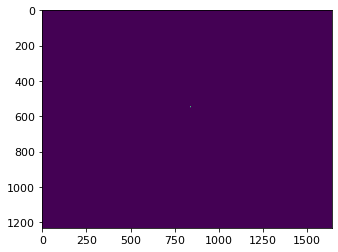

In [14]:
#Load and display an input frame
directory = r'..\Frames'
filename = 'frame_20210726_122641.jpg'
frame_in = load_image(filename, directory, grayscale = True)
plt.imshow(frame_in)
print('Maximum pixel value in the input frame: {:.0f}'.format(np.max(frame_in)))

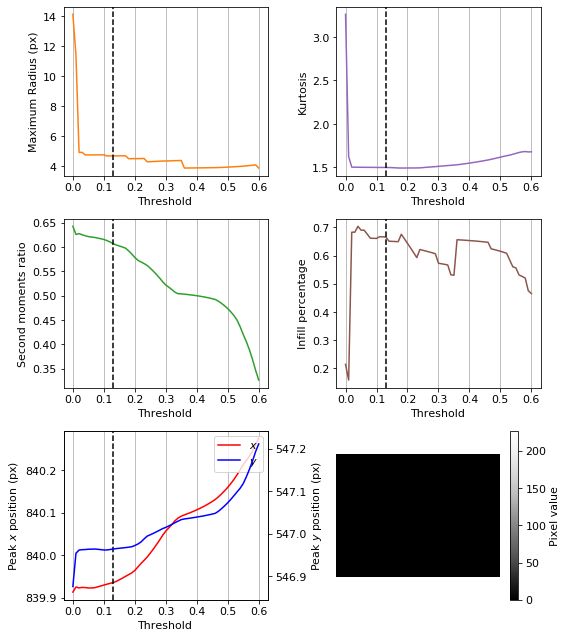

Optimum threshold: 0.13
Uncertainty in spot x position: 0.02 px
Uncertainty in spot y position: 0.0068 px


In [15]:
threshold, centre, second_moments_ratio, kurtosis, r_max, infill = spot_quality_parameters(frame_in)
threshold_optimum, x_uncertainty, y_uncertainty = adaptive_threshold(threshold, centre, second_moments_ratio, kurtosis, r_max, infill, filename)
threshold_plot(threshold, centre, second_moments_ratio, kurtosis, r_max, infill, threshold_optimum, filename, frame_in)
print('Optimum threshold: {:.2f}'.format(threshold_optimum))
print('Uncertainty in spot x position: {:.2g} px\n'
      'Uncertainty in spot y position: {:.2g} px'
      .format(x_uncertainty, y_uncertainty))

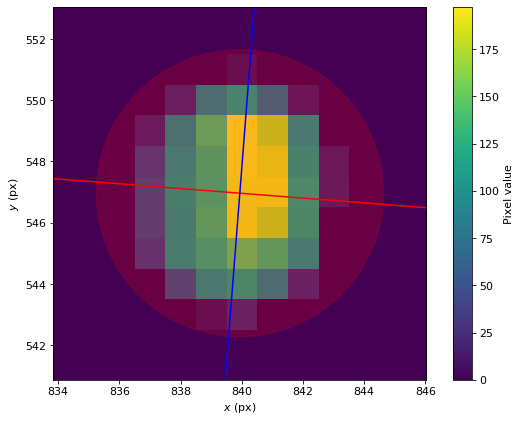

In [16]:
#Display the input frame thresholded using the optimum threshold value, indicate the major and minor principal axes of the intensity distribution, and overlay a circle on top of the high pixels. The circle is centred on the centre of mass coordinates and its radius extends to the furthest high pixel.
frame_threshold = threshold_image(frame_in, threshold_optimum)
peak = spot_centre(frame_threshold)
r_max = spot_radius(frame_threshold, peak)
second_moments_ratio, m1, m2, c1, c2 = spot_second_moments_ratio(frame_threshold, peak)

fig, ax = plt.subplots(1, 1, figsize = (8, 6))
x = np.arange(np.shape(frame_threshold)[1])
graph = ax.imshow(frame_threshold)

if m1 == np.inf: #Plot the principal axes
  ax.axvline(x = peak[0], color = 'r')
  ax.plot(x, (m2 * x) + c2, 'b-')
elif m2 == np.inf:
  ax.axvline(x = peak[0], color = 'b')
  ax.plot(x, (m1 * x) + c1, 'r-')
else:
  ax.plot(x, (m1 * x) + c1, 'r-')
  ax.plot(x, (m2 * x) + c2, 'b-')

circle = plt.Circle((peak[0], peak[1]), r_max, color = 'r', alpha = 0.2) #Compare the spot shape to a circle
ax.add_patch(circle)
ax.set_xlim(peak[0] - (r_max * 1.3), peak[0] + (r_max * 1.3)) #Zoom in on the high pixels
ax.set_ylim(peak[1] - (r_max * 1.3), peak[1] + (r_max * 1.3))
ax.set_aspect(1)
cbar = fig.colorbar(graph)
cbar.set_label('Pixel value')
ax.set_xlabel(r'$x$ (px)')
ax.set_ylabel(r'$y$ (px)')

plt.tight_layout()
plt.show()

## Cramer-Rao lower bound

In [16]:
folder = r'..\Frames'
filename = []
for f in os.listdir(folder):
    if f.startswith('frame_20210609_') & (not f.startswith('frame_20210609_10')) & (not f.endswith('122906.jpg')) & (not f.endswith('122907.jpg')) & (not f.endswith('122908.jpg')) & (not f.endswith('122909.jpg')) & (not f.endswith('122910.jpg')) & (not f.endswith('122911.jpg')) & (not f.endswith('122912.jpg')) & (not f.endswith('122913.jpg')) & (not f.endswith('122914.jpg')) & (not f.endswith('122915.jpg')):
        filename.append(f)

threshold = 0.15
n = int(len(filename))
CR_lower_bound = np.zeros(2 * n)
FWHM = np.zeros(2 * n)

for i in range(n):
    frame_in = load_image_CR(filename[i], folder)
    frame_threshold = threshold_image(frame_in, threshold)
    CR_lower_bound[i], FWHM[i] = cramer_rao(frame_threshold, 'x')
    CR_lower_bound[n + i], FWHM[n + i] = cramer_rao(frame_threshold, 'y')
CR_mean = np.mean(CR_lower_bound)
CR_std = np.std(CR_lower_bound, ddof = 1)

print('The average Cramer-Rao lower bound of the autocollimator is: {:.3f} px with a standard deviation of {:.1g} px'.format(CR_mean, CR_std))
print('The FWHM of the signal in the images collected during calibration after thresholding and reduction to 1D ranges\n'
      'between {:.0f} px and {:.0f} px'.format(FWHM.min(), FWHM.max()))

The average Cramer-Rao lower bound of the autocollimator is: 0.031 px with a standard deviation of 0.006 px
The FWHM of the signal in the images collected during calibration after thresholding and reduction to 1D ranges
between 3 px and 7 px


## Theoretical resolution

In [17]:
calibration = 0.22193485237391664 #px/arcsec
resolution = CR_mean / calibration
print('The theoretical resolution of the autocollimator is {:.3f} arcsec'.format(resolution))

The theoretical resolution of the autocollimator is 0.141 arcsec


## Threshold check

In [18]:
def next_number(input_number):
    if input_number.endswith('59'):
        next_number = int((int(input_number[:-2]) + 1) * 100)
    else:
        next_number = int(int(input_number) + 1)
    next_number = str(next_number)
    return next_number

In [19]:
with open(r'..\Experiments\Calibration_and_measurement_uncertainty\Data\Calibration\processed_data_20210609_120156.txt', 'r') as f:
    data = f.read().splitlines()

    centre_data = []
    for i in range(len(data)):
        if data[i][0].isdigit():
            data_list = ast.literal_eval(data[i])
            centre_data.append(data_list[1:])

    centre_data = np.array(centre_data)

In [20]:
folder = r'..\Frames'
filename = []
for f in os.listdir(folder):
    if f.startswith('frame_20210609_') & (not f.startswith('frame_20210609_10')) & (not f.endswith('122906.jpg')) & (not f.endswith('122907.jpg')) & (not f.endswith('122908.jpg')) & (not f.endswith('122909.jpg')) & (not f.endswith('122910.jpg')) & (not f.endswith('122911.jpg')) & (not f.endswith('122912.jpg')) & (not f.endswith('122913.jpg')) & (not f.endswith('122914.jpg')) & (not f.endswith('122915.jpg')):
        filename.append(f)

In [21]:
filename_time = []
regex = re.compile(r'\d+')
for i in range(len(filename)):
    filename_time.append(regex.findall(filename[i])[1])

In [22]:
filename_grouped = []
filename_temp = []

for i in range(len(filename_time) - 1):
    if filename_time[i + 1] == next_number(filename_time[i]):
        filename_temp.append('frame_20210609_' + filename_time[i] + '.jpg')
    else:
        filename_temp.append('frame_20210609_' + filename_time[i] + '.jpg')
        filename_grouped.append(filename_temp)
        filename_temp = []
        continue

filename_temp.append(filename[-1])
filename_grouped.append(filename_temp)

In [24]:
threshold = np.round(np.linspace(0.1, 0.8, 71), 2)
l = len(filename_grouped)
n = len(threshold)
centre_difference_mean = np.zeros((n, l))

for i in range(l):
    m = len(filename_grouped[i])
    centre_difference = np.zeros((n, m))
    for j in range(m):
        frame_in = load_image_CR(filename_grouped[i][j], folder)
        for k in range(n):
            frame_threshold = threshold_image(frame_in, threshold[k])
            peak = spot_centre(frame_threshold)
            centre_difference[k, j] = np.sqrt(np.sum((peak - centre_data[i])**2))
    centre_difference_mean[:, i] = np.mean(centre_difference, axis = 1)

centre_threshold = np.mean(centre_difference_mean, axis = 1)
threshold_index = np.argmin(centre_threshold)
threshold_used = threshold[threshold_index]
print('The threshold setting used in the calibration of the autocollimator is: {:.2f}'.format(threshold_used))

The threshold setting used in the calibration of the autocollimator is: 0.15


## Actual resolution of the optical system

In [18]:
with open(r'..\Experiments\Calibration_and_measurement_uncertainty\Data\Calibration\raw_data_20210609_120156.txt', 'r') as f:
    data = f.read().splitlines()

    measurement_uncertainty = []
    for i in range(len(data)):
        if data[i].startswith('[['):
            data_list = ast.literal_eval(data[i])
            data_array = np.array(data_list)
            standard_deviation = np.std(data_array, axis = 0, ddof = 1)
            measurement_uncertainty.append(standard_deviation)

measurement_uncertainty = np.array(measurement_uncertainty)
actual_optical_system_precision = np.mean(measurement_uncertainty, axis = 0)
actual_autocollimator_resolution = (np.sum(actual_optical_system_precision) / 2.0) / calibration
print('The standard deviation of measurement spot position between steps during calibration is\n'
      '{:.3f} px along the x axis of the camera and {:.3f} px along the y axis of the camera'
      .format(actual_optical_system_precision[0], actual_optical_system_precision[1]))
print('The actual resolution of the autocollimator is approximately {:.3f} arcsec'.format(actual_autocollimator_resolution))

The standard deviation of measurement spot position between steps during calibration is
0.020 px along the x axis of the camera and 0.024 px along the y axis of the camera
The actual resolution of the autocollimator is approximately 0.098 arcsec
